# Neural Machine Translation with Attention

Advanced Learning Fall 2024.   
Last updated: 2025-01-12


For SUBMISSION:   

Please upload the complete and executed `ipynb` to your git repository. Verify that all of your output can be viewed directly from github, and provide a link to that git file below.

~~~
STUDENT ID: 308308766
~~~

~~~
STUDENT GIT LINK: https://github.com/Nitzan93/52025-Course/tree/main/assignment_3
~~~
In Addition, don't forget to add your ID to the files, and upload to moodle the html version:    
  
`PS3_Attention_2024_ID_[000000000].html`   




In this problem set we are going to jump into the depths of `seq2seq` and `attention` and build a couple of PyTorch translation mechanisms with some  twists.     


*   Part 1 consists of a somewhat unorthodox `seq2seq` model for simple arithmetics
*   Part 2 consists of an `seq2seq - attention` language translation model. We will use it for Hebrew and English.  


---

A **seq2seq** model (sequence-to-sequence model) is a type of neural network designed specifically to handle sequences of data. The model converts input sequences into other sequences of data. This makes them particularly useful for tasks involving language, where the input and output are naturally sequences of words.

Here's a breakdown of how `seq2seq` models work:

* The encoder takes the input sequence, like a sentence in English, and processes it to capture its meaning and context.

* information is then passed to the decoder, which uses it to generate the output sequence, like a translation in French.

* Attention mechanism (optional): Some `seq2seq` models also incorporate an attention mechanism. This allows the decoder to focus on specific parts of the input sequence that are most relevant to generating the next element in the output sequence.

`seq2seq` models are used in many natural language processing (NLP) tasks.



imports: (feel free to add)

In [1]:
# from __future__ import unicode_literals, print_function, division
# from io import open
# import unicodedata
import re
import random
import unicodedata

import time
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Part 1: Seq2Seq Arithmetic model

**Using RNN `seq2seq` model to "learn" simple arithmetics!**

> Given the string "54-7", the model should return a prediction: "47".  
> Given the string "10+20", the model should return a prediction: "30".


- Watch Lukas Biewald's short [video](https://youtu.be/MqugtGD605k?si=rAH34ZTJyYDj-XJ1) explaining `seq2seq` models and his toy application (somewhat outdated).
- You can find the code for his example [here](https://github.com/lukas/ml-class/blob/master/videos/seq2seq/train.py).    



1.1) Using Lukas' code, implement a `seq2seq` network that can learn how to solve **addition AND substraction** of two numbers of maximum length of 4, using the following steps (similar to the example):      

* Generate data; X: queries (two numbers), and Y: answers   
* One-hot encode X and Y,
* Build a `seq2seq` network (with LSTM, RepeatVector, and TimeDistributed layers)
* Train the model.
* While training, sample from the validation set at random so we can visualize the generated solutions against the true solutions.    

Notes:  
* The code in the example is quite old and based on Keras. You might have to adapt some of the code to overcome methods/code that is not supported anymore. Hint: for the evaluation part, review the type and format of the "correct" output - this will help you fix the unsupported "model.predict_classes".
* Please use the parameters in the code cell below to train the model.     
* Instead of using a `wandb.config` object, please use a simple dictionary instead.   
* You don't need to run the model for more than 50 iterations (epochs) to get a gist of what is happening and what the algorithm is doing.
* Extra credit if you can implement the network in PyTorch (this is not difficult).    
* Extra credit if you are able to significantly improve the model.

# **Keras**

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, RepeatVector, Dense


params = {
    "training_size": 50000,
    "digits": 4,
    "hidden_size": 128,
    "batch_size": 128,
    "epochs": 50
}

maxlen = params["digits"] + 1 + params["digits"]
chars = "0123456789+- "
ctable = {
    "char_to_index": {c: i for i, c in enumerate(chars)},
    "index_to_char": {i: c for i, c in enumerate(chars)},
}

def encode(seq, maxlen, vocab_size):
    """One-hot encode the sequence."""
    x = np.zeros((maxlen, vocab_size), dtype=np.float32)
    for i, c in enumerate(seq):
        x[i, ctable["char_to_index"][c]] = 1
    return x

def decode(seq):
    """Decode one-hot encoded sequence."""
    indices = seq.argmax(axis=-1)
    return ''.join(ctable["index_to_char"][idx] for idx in indices)

# Data Generation
questions = []
answers = []
seen = set()
while len(questions) < params["training_size"]:
    a = random.randint(0, 10 ** params["digits"] - 1)
    b = random.randint(0, 10 ** params["digits"] - 1)
    operation = random.choice(["+", "-"])
    query = f"{a}{operation}{b}"
    if query in seen:
        continue
    seen.add(query)
    result = eval(query)  # Calculate the result
    questions.append(query.ljust(maxlen))  # Padded to maxlen
    answers.append(str(result).ljust(params["digits"] + 1))  # Padded to output length

vocab_size = len(chars)
x = np.zeros((len(questions), maxlen, vocab_size), dtype=np.float32)
y = np.zeros((len(questions), params["digits"] + 1, vocab_size), dtype=np.float32)

for i, (question, answer) in enumerate(zip(questions, answers)):
    x[i] = encode(question, maxlen, vocab_size)
    y[i] = encode(answer, params["digits"] + 1, vocab_size)

# Train / Test Split
split_at = len(x) - len(x) // 10
x_train, x_val = x[:split_at], x[split_at:]
y_train, y_val = y[:split_at], y[split_at:]

# Model Definition
model = Sequential()
model.add(LSTM(params["hidden_size"], input_shape=(maxlen, vocab_size)))
model.add(RepeatVector(params["digits"] + 1))
model.add(LSTM(params["hidden_size"], return_sequences=True))
model.add(TimeDistributed(Dense(vocab_size, activation="softmax")))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Training
for epoch in range(params["epochs"]):
    print(f"Epoch {epoch+1}/{params['epochs']}")
    model.fit(x_train, y_train, batch_size=params["batch_size"], epochs=1, validation_data=(x_val, y_val))
    # Test predictions on random samples
    indices = np.random.randint(0, len(x_val), 10)
    for idx in indices:
        q = decode(x_val[idx])
        t = decode(y_val[idx])
        p = decode(model.predict(x_val[idx:idx+1])[0])
        print(f"Q: {q.strip()} | True: {t.strip()} | Pred: {p.strip()}")

Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 26s 57ms/step - accuracy: 0.2173 - loss: 2.2427 - val_accuracy: 0.2785 - val_loss: 1.9883
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
Q: 876-2779 | True: -1903 | Pred: -222
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Q: 6521+9269 | True: 15790 | Pred: 1002
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Q: 863-6340 | True: -5477 | Pred: -222
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Q: 621-6562 | True: -5941 | Pred: -222
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Q: 8333-4169 | True: 4164 | Pred: -22
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Q: 9013-3191 | True: 5822 | Pred: 222
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Q: 6323+9541 | True: 15864 | Pred: 1002
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Q: 5475-7740 | True: -2265 | Pred: -222
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Q: 5545+2995 | True: 8540 | Pred: 1002
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Q: 7625+4155 | True: 11780 | Pred: 1002
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.2856 - loss: 1.9536 - val_acc

# **PyTorch**

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

# Parameters
params = {
    "training_size": 50000,
    "digits": 4,
    "hidden_size": 128,
    "embed_dim": 32,
    "batch_size": 128,
    "epochs": 50,
    "lr": 0.001,
}

maxlen = params["digits"] + 1 + params["digits"]  # Input sequence length
chars = "0123456789+- "
vocab_size = len(chars)

# Character Table
ctable = {
    "char_to_index": {c: i for i, c in enumerate(chars)},
    "index_to_char": {i: c for i, c in enumerate(chars)},
}

# Data Encoding
def encode(seq, maxlen):
    x = np.zeros((maxlen, vocab_size), dtype=np.float32)
    for i, c in enumerate(seq):
        x[i, ctable["char_to_index"][c]] = 1
    return x

def decode(seq):
    indices = seq.argmax(axis=-1)
    return ''.join(ctable["index_to_char"][idx] for idx in indices)

# Generate Data
questions, answers = [], []
seen = set()
while len(questions) < params["training_size"]:
    a = random.randint(0, 10 ** params["digits"] - 1)
    b = random.randint(0, 10 ** params["digits"] - 1)
    operation = random.choice(["+", "-"])
    query = f"{a}{operation}{b}"
    if query in seen:
        continue
    seen.add(query)
    result = str(eval(query))
    questions.append(query.ljust(maxlen))
    answers.append(result.ljust(params["digits"] + 1))

x = np.zeros((len(questions), maxlen, vocab_size), dtype=np.float32)
y = np.zeros((len(questions), params["digits"] + 1, vocab_size), dtype=np.float32)
for i, (question, answer) in enumerate(zip(questions, answers)):
    x[i] = encode(question, maxlen)
    y[i] = encode(answer, params["digits"] + 1)

# Train/Test Split
split_at = len(x) - len(x) // 10
x_train, x_val = x[:split_at], x[split_at:]
y_train, y_val = y[:split_at], y[split_at:]

# Convert to PyTorch tensors
x_train, y_train = torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
x_val, y_val = torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)

# Model Definition
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, output_len):
        super(Seq2Seq, self).__init__()
        self.embedding = nn.Linear(vocab_size, embed_dim)
        self.encoder = nn.LSTM(embed_dim, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(embed_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        # Encoding
        embedded = self.embedding(x)
        _, (hidden, cell) = self.encoder(embedded)

        # Decoding
        decoder_input = torch.zeros(embedded.size(0), 1, embedded.size(-1)).to(embedded.device)
        outputs = []
        for _ in range(params["digits"] + 1):
            output, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
            step_output = self.fc(output.squeeze(1))
            outputs.append(step_output.unsqueeze(1))
            decoder_input = self.embedding(step_output.softmax(-1)).unsqueeze(1)  # Feedback prediction

        return torch.cat(outputs, dim=1)

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Seq2Seq(vocab_size, params["embed_dim"], params["hidden_size"], params["digits"] + 1).to(device)

# Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=params["lr"])

# Training Loop
for epoch in range(params["epochs"]):
    model.train()
    total_loss = 0
    for i in range(0, len(x_train), params["batch_size"]):
        x_batch = x_train[i:i+params["batch_size"]].to(device)
        y_batch = y_train[i:i+params["batch_size"]].to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs.view(-1, vocab_size), y_batch.argmax(-1).view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(x_val.to(device))
        val_loss = criterion(val_outputs.view(-1, vocab_size), y_val.argmax(-1).view(-1))

        # Accuracy Calculation
        val_preds = val_outputs.argmax(-1).cpu().numpy()
        val_targets = y_val.argmax(-1).cpu().numpy()
        correct = 0
        total = 0
        for pred_seq, target_seq in zip(val_preds, val_targets):
            for pred_char, target_char in zip(pred_seq, target_seq):
                if pred_char == target_char:
                    correct += 1
                total += 1
        accuracy = correct / total

    print(f"Epoch {epoch+1}/{params['epochs']}, Loss: {total_loss/len(x_train):.4f}, "
          f"Val Loss: {val_loss.item():.4f}, Accuracy: {accuracy:.4f}")

    # Print examples
    if epoch % 10 == 0 or epoch == params["epochs"] - 1:
        indices = np.random.randint(0, len(x_val), 5)
        for idx in indices:
            q = decode(x_val[idx].cpu().numpy())
            t = decode(y_val[idx].cpu().numpy())
            p = decode(val_outputs[idx].detach().cpu().numpy())
            print(f"Q: {q.strip()} | True: {t.strip()} | Pred: {p.strip()}")

Epoch 1/50, Loss: 0.0166, Val Loss: 2.0417, Accuracy: 0.2742
Q: 8897+1019 | True: 9916 | Pred: 1119
Q: 6672+3345 | True: 10017 | Pred: 1019
Q: 457-2491 | True: -2034 | Pred: -236
Q: 8594+9957 | True: 18551 | Pred: 11119
Q: 4640+7946 | True: 12586 | Pred: 1019
Epoch 2/50, Loss: 0.0149, Val Loss: 1.8173, Accuracy: 0.3248
Epoch 3/50, Loss: 0.0138, Val Loss: 1.7091, Accuracy: 0.3559
Epoch 4/50, Loss: 0.0131, Val Loss: 1.6548, Accuracy: 0.3706
Epoch 5/50, Loss: 0.0127, Val Loss: 1.6088, Accuracy: 0.3996
Epoch 6/50, Loss: 0.0125, Val Loss: 1.5770, Accuracy: 0.4116
Epoch 7/50, Loss: 0.0123, Val Loss: 1.5585, Accuracy: 0.4112
Epoch 8/50, Loss: 0.0121, Val Loss: 1.5317, Accuracy: 0.4226
Epoch 9/50, Loss: 0.0120, Val Loss: 1.5146, Accuracy: 0.4272
Epoch 10/50, Loss: 0.0119, Val Loss: 1.5010, Accuracy: 0.4301
Epoch 11/50, Loss: 0.0118, Val Loss: 1.4900, Accuracy: 0.4357
Q: 5916-3703 | True: 2213 | Pred: 2199
Q: 8615-8058 | True: 557 | Pred: 103
Q: 500+4359 | True: 4859 | Pred: 5199
Q: 5218+35 | T

# **Improved Model**

Larger hidden size, smaller input size, embedding before LSTM, sparse categorial crossentropy loss function and integer encoding.

In [15]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, TimeDistributed, RepeatVector

# Updated Hyperparameters
params = {
    "training_size": 50000,
    "digits": 4,
    "hidden_size": 256,  # Increased hidden size
    "embedding_size": 50,  # Embedding dimension
    "batch_size": 128,
    "epochs": 50
}

maxlen = params["digits"] + 1 + params["digits"]
chars = "0123456789+- "
vocab_size = len(chars)
ctable = {
    "char_to_index": {c: i for i, c in enumerate(chars)},
    "index_to_char": {i: c for i, c in enumerate(chars)},
}

def encode(seq, maxlen):
    """Integer encode the sequence."""
    x = [ctable["char_to_index"][c] for c in seq]
    return np.array(x + [0] * (maxlen - len(seq)))

def decode(seq):
    """Decode integer-encoded sequence."""
    return ''.join(ctable["index_to_char"][idx] for idx in seq)

# Data Generation
questions = []
answers = []
seen = set()
while len(questions) < params["training_size"]:
    a = random.randint(0, 10 ** params["digits"] - 1)
    b = random.randint(0, 10 ** params["digits"] - 1)
    operation = random.choice(["+", "-"])
    query = f"{a}{operation}{b}"
    if query in seen:
        continue
    seen.add(query)
    result = eval(query)  # Calculate the result
    questions.append(query.ljust(maxlen))  # Padded to maxlen
    answers.append(str(result).ljust(params["digits"] + 1))  # Padded to output length

x = np.array([encode(q, maxlen) for q in questions])
y = np.array([encode(a, params["digits"] + 1) for a in answers])

# Train / Test Split
split_at = len(x) - len(x) // 10
x_train, x_val = x[:split_at], x[split_at:]
y_train, y_val = y[:split_at], y[split_at:]

# Model Definition with Embedding and Two LSTMs
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=params["embedding_size"], input_length=maxlen))  # Embedding Layer
model.add(LSTM(params["hidden_size"]))  # Single Encoder LSTM Layer
model.add(RepeatVector(params["digits"] + 1))  # Repeat vector for Decoder
model.add(LSTM(params["hidden_size"], return_sequences=True))  # Decoder LSTM
model.add(TimeDistributed(Dense(vocab_size, activation="softmax")))  # Dense Output Layer


model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Training
for epoch in range(params["epochs"]):
    print(f"Epoch {epoch+1}/{params['epochs']}")
    model.fit(
        x_train,
        y_train,
        batch_size=params["batch_size"],
        epochs=1,
        validation_data=(x_val, y_val),
        verbose=1
    )

    # Test predictions on random samples
    indices = np.random.randint(0, len(x_val), 10)
    for idx in indices:
        q = decode(x_val[idx])
        t = decode(y_val[idx])
        pred_probs = model.predict(x_val[idx:idx + 1])
        pred = decode(np.argmax(pred_probs, axis=-1)[0])
        print(f"Q: {q.strip()} | True: {t.strip()} | Pred: {pred.strip()}")

Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 60s 153ms/step - accuracy: 0.2279 - loss: 2.2064 - val_accuracy: 0.2846 - val_loss: 1.9358
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
Q: 7006+9197 | True: 16203 | Pred: 12244
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Q: 2242-504 | True: 1738 | Pred: -155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Q: 4314+9353 | True: 13667 | Pred: 12244
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Q: 2841+9821 | True: 12662 | Pred: 12244
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Q: 3343-9269 | True: -5926 | Pred: -2455
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Q: 6530+7665 | True: 14195 | Pred: 12244
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Q: 4926-7275 | True: -2349 | Pred: -255
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Q: 7528-9394 | True: -1866 | Pred: -255
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Q: 8582+8792 | True: 17374 | Pred: 11144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Q: 3625+4905 | True: 8530 | Pred: 12244
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 55s 157ms/step - accuracy: 0.3144 - loss: 1.

1.2).

a) Do you think this model performs well?  Why or why not?     
b) What are its limitations?   
c) What would you do to improve it?    
d) Can you apply an attention mechanism to this model? Why or why not?   

# **ANSWERS FOR 1.2**

# **a)**

The model performs reasonably well but has noticeable shortcomings that affect its overall reliability.

Strengths:

1) Ability to Learn Basic Patterns:

The model can generate predictions that are often close to the correct outputs, indicating that it has learned some patterns of addition and subtraction.

Training loss consistently decreases, showing the model effectively minimizes errors on the training set.

2) Handling a Range of Inputs:

The model performs adequately on randomly generated equations, showing it has generalized to a reasonable extent, especially for simpler cases.


Weaknesses:

1) Validation Loss Fluctuations:

The validation loss fluctuates significantly and does not decrease as consistently as the training loss. This indicates the model struggles to generalize well to unseen data, potentially due to overfitting.

2) Prediction Errors:

The model makes some errors that deviate significantly from the correct answers.

These errors may result from error propagation during decoding, where incorrect predictions in earlier time steps negatively affect later steps.

3) Mismatch Between Training and Inference (Teacher Forcing):

The model uses ground truth during training (teacher forcing) but relies on its own predictions during inference. This discrepancy can lead to cascading errors during testing.

4) Simplistic Design:

The model lacks attention mechanisms or other strategies that might help it focus on relevant parts of the input sequence, limiting its ability to handle more complex or edge case inputs.

Overall Performance:

The model performs adequately for simple examples but struggles with generalization and robustness, particularly for more complex or edge case inputs. its limitations, such as fluctuating validation loss and occasional large prediction errors, indicate that improvements are needed for reliable performance across all cases.

In conclusion, the model performs moderately well but does not consistently achieve high accuracy, particularly on unseen data.

# **b)**
1) Error Propagation in Decoding Without Teacher Forcing:

During inference, the model relies on its own predictions to generate the next input (instead of ground truth), leading to error accumulation. If an early prediction is incorrect, it can mislead subsequent predictions, especially for longer sequences.
This can result in cascading errors, particularly for more complex problems or larger numbers.

2) Lack of Rich Semantic Embedding:

The embedding in the Keras implementation is implemented as a dense layer, which is less robust compared to learned embeddings like PyTorch's nn.Embedding. It treats input tokens as isolated entities and doesn't leverage relationships or patterns between them effectively.
This limits the model’s ability to capture deeper structural relationships.

3) Overfitting to Training Data:

The model could memorize patterns in the training data, particularly when the training set is small or lacks diversity.
This would reduce its ability to generalize to unseen or edge case equations.

4) Lack of Attention Mechanism:

The model lacks an attention mechanism, which could help it focus on specific parts of the input sequence during decoding.
Without attention, the model processes all input tokens uniformly, which may hinder its ability to learn complex, position specific dependencies effectively.

# **c)**

1) Use a Learned Embedding Layer:
The current embedding is a dense layer, which is less effective at capturing semantic relationships between input tokens.
Replace the dense layer embedding with a proper learned embedding layer (for example PyTorch’s nn.Embedding). This approach will
Learn a distributed representation of tokens during training and Better capture patterns and relationships between input tokens.

2) Incorporate Attention Mechanisms:
The model processes the input uniformly and struggles with position specific dependencies.
The solution is to Add an attention mechanism to the decoder. This would allow the model to focus on relevant parts of the input sequence during each decoding step.
This would enhance the model’s ability to handle long term dependencies and improve accuracy on complex arithmetic tasks.

3) Use Pretraining or Transfer Learning:

The model is trained from scratch, which can be slow and suboptimal for learning general patterns.
Solution: Pretrain the encoder or decoder on related tasks (for example language modeling or sequence prediction) and fine tune for arithmetic tasks.
Pretraining provides the model with a strong initialization, leading to faster convergence and improved performance.

# **d)**
Yes, attention can be integrated into this model because:

1) Encoder-Decoder Architecture: Attention mechanisms are designed to work with encoder-decoder setups like the one in this model.

2) Compatibility: Attention does not fundamentally alter the structure but enhances it by modifying how the decoder accesses the encoder’s output.

3) Task Relevance: For sequence to sequence tasks like arithmetic equation solving, attention can help the model identify relevant parts of the input sequence for generating each output token.

1.3).  

Add attention to the model. Evaluate the performance against the `seq2seq` you trained above. Which one is performing better?

# **Answers for 1.3)**

Performance:

Accuracy: The model with attention achieves 56.5% training accuracy and 54.9% validation accuracy by the final epoch. While slightly lower than the basic model’s best accuracy, the attention model performs better in handling long sequences and edge cases.

mproved Predictions:
Predictions are closer to the true values compared to the vanilla model, especially for longer or more complex sequences.
For examples:

Q: 7851+2214 | True: 10065 | Pred: 10002 → Small error compared to larger deviations in the vanilla model.

Q: 3910+4285 | True: 8195 | Pred: 8177 → More accurate than without attention.

Benefits of Attention:

Dynamic Context: The attention mechanism overcomes the bottleneck of a fixed length context vector by dynamically attending to relevant parts of the input sequence.

Improved Long Sequence Handling: Predictions for longer sequences are more accurate and consistent.

Error Reduction: The attention mechanism reduces large errors, particularly for sequences requiring precise arithmetic operations.

The results show that while both models achieve similar overall accuracy, the attention mechanism provides a significant qualitative improvement in handling complex and longer sequences.


Qualitative Performance:

Error Handling:

Without Attention:
The predictions often deviate significantly for longer or complex sequences. Inaccurate for subtraction.

With Attention:

Errors are smaller and more localized.

Handling of Long Sequences:

The model with attention handles long sequences and complex operations better by focusing dynamically on relevant parts of the input.

The fixed length context vector of the model without attention causes performance degradation for such cases.

The attention mechanism provides a better ability to generalize to unseen or complex inputs. While its overall accuracy is slightly lower, it shows better alignment between input and output patterns, especially for tasks requiring more nuanced understanding.


# **Code with Attention Mechanism**

In [ ]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, TimeDistributed, RepeatVector, Dot, Activation, Concatenate

# Parameters
params = {
    "training_size": 50000,
    "digits": 4,
    "hidden_size": 128,
    "batch_size": 128,
    "epochs": 50
}

maxlen = params["digits"] + 1 + params["digits"]
chars = "0123456789+- "
vocab_size = len(chars)

# Character Table
ctable = {
    "char_to_index": {c: i for i, c in enumerate(chars)},
    "index_to_char": {i: c for i, c in enumerate(chars)},
}

# Encoding/Decoding Functions
def encode(seq, maxlen, vocab_size):
    x = np.zeros((maxlen, vocab_size), dtype=np.float32)
    for i, c in enumerate(seq):
        x[i, ctable["char_to_index"][c]] = 1
    return x

def decode(seq):
    indices = seq.argmax(axis=-1)
    return ''.join(ctable["index_to_char"][idx] for idx in indices)

# Generate Data
questions = []
answers = []
seen = set()
while len(questions) < params["training_size"]:
    a = random.randint(0, 10 ** params["digits"] - 1)
    b = random.randint(0, 10 ** params["digits"] - 1)
    operation = random.choice(["+", "-"])
    query = f"{a}{operation}{b}"
    if query in seen:
        continue
    seen.add(query)
    result = eval(query)
    questions.append(query.ljust(maxlen))
    answers.append(str(result).ljust(params["digits"] + 1))

x = np.zeros((len(questions), maxlen, vocab_size), dtype=np.float32)
y = np.zeros((len(questions), params["digits"] + 1, vocab_size), dtype=np.float32)
for i, (question, answer) in enumerate(zip(questions, answers)):
    x[i] = encode(question, maxlen, vocab_size)
    y[i] = encode(answer, params["digits"] + 1, vocab_size)

# Train / Test Split
split_at = len(x) - len(x) // 10
x_train, x_val = x[:split_at], x[split_at:]
y_train, y_val = y[:split_at], y[split_at:]

# Prepare Decoder Inputs
decoder_inputs_train = np.zeros_like(y_train)
decoder_inputs_train[:, 1:, :] = y_train[:, :-1, :]
decoder_inputs_train[:, 0, ctable["char_to_index"][" "]] = 1

decoder_inputs_val = np.zeros_like(y_val)
decoder_inputs_val[:, 1:, :] = y_val[:, :-1, :]
decoder_inputs_val[:, 0, ctable["char_to_index"][" "]] = 1

# Model Definition with Attention
encoder_inputs = Input(shape=(maxlen, vocab_size))
encoder_lstm = LSTM(params["hidden_size"], return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, vocab_size))
decoder_lstm = LSTM(params["hidden_size"], return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

attention_dot = Dot(axes=[2, 2])([decoder_outputs, encoder_outputs])
attention_softmax = Activation('softmax')(attention_dot)
context_vector = Dot(axes=[2, 1])([attention_softmax, encoder_outputs])
decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])

output_dense = TimeDistributed(Dense(vocab_size, activation="softmax"))
decoder_predictions = output_dense(decoder_combined_context)

attention_model = Model([encoder_inputs, decoder_inputs], decoder_predictions)
attention_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Training
attention_model.fit(
    [x_train, decoder_inputs_train],
    y_train,
    batch_size=params["batch_size"],
    epochs=params["epochs"],
    validation_data=([x_val, decoder_inputs_val], y_val)
)

# Evaluate Model
for _ in range(10):
    idx = np.random.randint(0, len(x_val))
    q = decode(x_val[idx])
    t = decode(y_val[idx])
    p = decode(attention_model.predict([x_val[idx:idx+1], decoder_inputs_val[idx:idx+1]])[0])
    print(f"Q: {q.strip()} | True: {t.strip()} | Pred: {p.strip()}")

Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.2492 - loss: 2.1565 - val_accuracy: 0.2936 - val_loss: 1.9130
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.2948 - loss: 1.8914 - val_accuracy: 0.3076 - val_loss: 1.8328
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.3136 - loss: 1.8134 - val_accuracy: 0.3415 - val_loss: 1.7428
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 40s 61ms/step - accuracy: 0.3448 - loss: 1.7202 - val_accuracy: 0.3568 - val_loss: 1.6798
Epoch 5/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.3671 - loss: 1.6578 - val_accuracy: 0.3808 - val_loss: 1.6195
Epoch 6/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.3886 - loss: 1.6119 - val_accuracy: 0.3900 - val_loss: 1.5922
Epoch 7/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 40s 58ms/step - accuracy: 0.3987 - loss: 1.5817 - val_accuracy: 0.4042 - val_loss: 1.5616
Epoch 8/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.4107 - loss: 1.5523 - 

1.4)

Using any neural network architecture of your liking, build  a model with the aim to beat the best performing model in 1.1 or 1.3. Compare your results in a meaningful way, and add a short explanation to why you think/thought your suggested network is better.

# **Answer 1.4)**

Enhanced Gradient Flow and Input Preservation:

Residual connections help retain input features and improve gradient flow, especially in deeper architectures. This leads to more stable training and better convergence.

Stable Learning Dynamics:

Layer normalization ensures consistent and stable updates during training, reducing variance in gradient updates.

Improved Attention Mechanism:

Scaled dot product attention improves numerical stability and allows the model to better focus on relevant parts of the sequence, particularly beneficial for long term dependencies.

Better Generalization:

The learning rate scheduler dynamically adjusts the learning rate, leading to better generalization on validation data as training progresses.

Efficient Encoding:

The integer encoding combined with embedding and projection layers reduces memory usage and computation overhead compared to one hot encoding.


The code in 1.4 integrates advanced techniques (residual connections, normalization, scaled attention, and learning rate scheduling) that improve the model’s ability to learn complex patterns, focus on important parts of the input sequence, and generalize better. These additions come at the cost of longer training times but lead to better overall accuracy and robustness in predictions.

It is better in accuracy and generalization, especially for larger or more complex datasets. While it may not be as fast as simpler models, it’s better suited for tasks requiring high precision and stability.

In [13]:
config = {}
config["training_size"] = 40000
config["digits"] = 4
config["hidden_size"] = 128
config["batch_size"] = 128
config["iterations"] = 50
chars = '0123456789-+ '

SOLUTION:

In [14]:
import tensorflow as tf
from keras.layers import Input, GRU, Dense, TimeDistributed, Concatenate, Embedding, Dropout, LayerNormalization, Add, Dot, Activation
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler


config = {
    "training_size": 40000,
    "digits": 4,
    "hidden_size": 256,
    "embedding_size": 50,
    "batch_size": 128,
    "epochs": 50,
    "learning_rate": 0.001
}

maxlen = config["digits"] + 1 + config["digits"]
chars = "0123456789+- "
vocab_size = len(chars)

# Character Table
ctable = {
    "char_to_index": {c: i for i, c in enumerate(chars)},
    "index_to_char": {i: c for i, c in enumerate(chars)},
}

# Encoding/Decoding Functions
def encode(seq, maxlen):
    """Integer encode the sequence."""
    x = [ctable["char_to_index"][c] for c in seq]
    return np.array(x + [0] * (maxlen - len(seq)))

def decode(seq):
    """Decode integer-encoded sequence."""
    return ''.join(ctable["index_to_char"][idx] for idx in seq)

# Generate Data
questions = []
answers = []
seen = set()
while len(questions) < config["training_size"]:
    a = random.randint(0, 10 ** config["digits"] - 1)
    b = random.randint(0, 10 ** config["digits"] - 1)
    operation = random.choice(["+", "-"])
    query = f"{a}{operation}{b}"
    if query in seen:
        continue
    seen.add(query)
    result = eval(query)
    questions.append(query.ljust(maxlen))
    answers.append(str(result).ljust(config["digits"] + 1))

x = np.array([encode(q, maxlen) for q in questions])
y = np.array([encode(a, config["digits"] + 1) for a in answers])

# Train / Test Split
split_at = len(x) - len(x) // 10
x_train, x_val = x[:split_at], x[split_at:]
y_train, y_val = y[:split_at], y[split_at:]

# Prepare Decoder Inputs
decoder_inputs_train = np.zeros_like(y_train)
decoder_inputs_train[:, 1:] = y_train[:, :-1]
decoder_inputs_train[:, 0] = ctable["char_to_index"][" "]

decoder_inputs_val = np.zeros_like(y_val)
decoder_inputs_val[:, 1:] = y_val[:, :-1]
decoder_inputs_val[:, 0] = ctable["char_to_index"][" "]

# Model Definition
encoder_inputs = Input(shape=(maxlen,))
embedding = Embedding(input_dim=vocab_size, output_dim=config["embedding_size"])(encoder_inputs)
embedded_norm = LayerNormalization()(embedding)

# Project embedding to match hidden size
projected_embedding = Dense(config["hidden_size"])(embedded_norm)

# Encoder
encoder_gru = GRU(config["hidden_size"], return_sequences=True, return_state=True, dropout=0.3)
encoder_outputs, state_h = encoder_gru(projected_embedding)

# Residual Connection
encoder_outputs = Add()([projected_embedding, encoder_outputs])

# Decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=config["embedding_size"])(decoder_inputs)
decoder_gru = GRU(config["hidden_size"], return_sequences=True, return_state=True, dropout=0.3)
decoder_outputs, _ = decoder_gru(decoder_embedding, initial_state=state_h)

# Scaled Dot Product Attention
attention_scores = Dot(axes=[2, 2])([decoder_outputs, encoder_outputs])
scale = tf.Variable(1.0, trainable=True, dtype=tf.float32, name="attention_scale")
attention_scores = attention_scores * scale
attention_softmax = Activation('softmax')(attention_scores)
context_vector = Dot(axes=[2, 1])([attention_softmax, encoder_outputs])
decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])

# Output Layer
output_dense = TimeDistributed(Dense(vocab_size, activation="softmax"))
decoder_predictions = output_dense(decoder_combined_context)

# Compile Model
model = Model([encoder_inputs, decoder_inputs], decoder_predictions)
optimizer = Adam(learning_rate=config["learning_rate"])
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch > 20:
        return lr * 0.5
    return lr

lr_scheduler = LearningRateScheduler(scheduler)

# Training
model.fit(
    [x_train, decoder_inputs_train],
    np.expand_dims(y_train, -1),
    batch_size=config["batch_size"],
    epochs=config["epochs"],
    validation_data=([x_val, decoder_inputs_val], np.expand_dims(y_val, -1)),
    callbacks=[lr_scheduler]
)

# Evaluate Model
for _ in range(10):
    idx = np.random.randint(0, len(x_val))
    q = decode(x_val[idx])
    t = decode(y_val[idx])
    p = decode(model.predict([x_val[idx:idx+1], decoder_inputs_val[idx:idx+1]])[0].argmax(axis=-1))
    print(f"Q: {q.strip()} | True: {t.strip()} | Pred: {p.strip()}")

Epoch 1/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 50s 150ms/step - accuracy: 0.2622 - loss: 2.0756 - val_accuracy: 0.3479 - val_loss: 1.7206 - learning_rate: 0.0010
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 41s 146ms/step - accuracy: 0.3646 - loss: 1.6795 - val_accuracy: 0.4099 - val_loss: 1.5623 - learning_rate: 0.0010
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 82s 146ms/step - accuracy: 0.4091 - loss: 1.5541 - val_accuracy: 0.4293 - val_loss: 1.5001 - learning_rate: 0.0010
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 82s 145ms/step - accuracy: 0.4285 - loss: 1.4960 - val_accuracy: 0.4389 - val_loss: 1.4618 - learning_rate: 0.0010
Epoch 5/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 82s 147ms/step - accuracy: 0.4435 - loss: 1.4532 - val_accuracy: 0.4515 - val_loss: 1.4208 - learning_rate: 0.0010
Epoch 6/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 82s 147ms/step - accuracy: 0.4574 - loss: 1.4135 - val_accuracy: 0.4711 - val_loss: 1.3740 - learning_rate: 0.0010
Epoch 7/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 82s 146ms/step - accuracy: 0.4

---

## Part 2: A language translation model with attention

In this part of the problem set we are going to implement a translation with a Sequence to Sequence Network and Attention model.

0) Please go over the NLP From Scratch: Translation with a Sequence to Sequence Network and Attention [tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html). This attention model is very similar to what was learned in class (Luong), but a bit different. What are the main differences between  Badahnau and Luong attention mechanisms?    



# **Answer 0)**

Bahdanau Attention:

Additive Attention: Combines the decoders hidden state and encoders outputs using a feed forward neural network with non-linearity (for example tanh).

Each alignment score is calculated individually for each source word.

It combines information from both the encoder and decoder hidden states via a concatenation operation and a learned transformation.
The non linear transformation allows for flexible learning of complex dependencies.

This makes Bahdanau attention more expressive and capable of learning nuanced alignments.

Luong Attention:

Multiplicative Attention: Uses dot products between the decoder hidden state and encoder outputs.

Provides global and local attention options:

Global focuses on the full input sequence.
Local limits the focus to a subset of the input sequence.
Computationally more efficient than Bahdanau.

The dot product measures the similarity between the encoder and decoder hidden states.

No additional parameters are learned for alignment scoring, making this mechanism simpler and computationally efficient.

The attention mechanisms ability to learn is limited compared to Bahdanau attention because there is no transformation or added flexibility.

1.a) Using `!wget`, `!unzip` , download and extract the [hebrew-english](https://www.manythings.org/anki/) sentence pairs text file to the Colab `content/`  folder (or local folder if not using Colab).
1.b) The `heb.txt` must be parsed and cleaned (see tutorial for requirements or change the code as you see fit).   


# **Answer 1)**

In [35]:
# Step 1.a: Download and extract the file
def download_and_extract_data():
    import os

    if not os.path.exists("heb-eng.zip"):
        !wget https://www.manythings.org/anki/heb-eng.zip

    if not os.path.exists("heb.txt"):
        !unzip heb-eng.zip

# Call the function to ensure data is downloaded and extracted
download_and_extract_data()

# Step 1.b: Parse and clean the data
def parse_and_clean_data(file_path):
    """
    Parse and clean the heb.txt file.
    - Remove punctuation and convert text to lowercase.
    - Split into sentence pairs.
    - Return processed data.
    """
    import string

    # Read the file
    with open(file_path, encoding="utf-8") as f:
        lines = f.read().strip().split("\n")

    # Split lines into sentence pairs (Hebrew-English → English-Hebrew)
    sentence_pairs = [line.split("\t")[:2] for line in lines]

    # Swap the order of Hebrew and English
    sentence_pairs = [(pair[1], pair[0]) for pair in sentence_pairs]

    # Define a function to clean text
    def clean_text(text):
        text = text.lower().strip()
        text = text.translate(str.maketrans("", "", string.punctuation))
        return text

    # Clean both English and Hebrew sentences
    cleaned_pairs = [(clean_text(pair[0]), clean_text(pair[1])) for pair in sentence_pairs]

    return cleaned_pairs

# Parse and clean the data
file_path = "heb.txt"
cleaned_data = parse_and_clean_data(file_path)

# Display a sample of the cleaned data
for i in range(5):
    print(f"Hebrew: {cleaned_data[i][0]} | English: {cleaned_data[i][1]}")

print(f"Total sentence pairs: {len(cleaned_data)}")


Hebrew: לך | English: go
Hebrew: היי | English: hi
Hebrew: אהלן | English: hi
Hebrew: רוץ | English: run
Hebrew: רוצי | English: run
Total sentence pairs: 128133


2.a) Use the tutorial example to build  and train a Hebrew to English translation model with attention (using the parameters in the code cell below). Apply the same `eng_prefixes` filter to limit the train/test data.   
2.b) Evaluate your trained model randomly on 20 sentences.  
2.c) Show the attention plot for 5 random sentences.  


# **Answer 2)**

# **2a + 2b**

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import re
import math
import time

# Parameters
MAX_LENGTH = 10
hidden_size = 128
epochs = 50
SOS_token = 0
EOS_token = 1

# Helper Functions
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {s:.0f}s'

def timeSince(since, percent):
    now = time.time()
    elapsed = now - since
    estimated_total = elapsed / percent
    remaining = estimated_total - elapsed
    return f'{asMinutes(elapsed)} (- {asMinutes(remaining)})'

# Language Class
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Preprocess Data
def prepareData(lang1, lang2, pairs):
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    print(f"Read {len(pairs)} sentence pairs")
    pairs = [pair for pair in pairs if len(pair[0].split()) < MAX_LENGTH and len(pair[1].split()) < MAX_LENGTH]
    print(f"Trimmed to {len(pairs)} sentence pairs")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

# Encoder Model
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

# Decoder with Attention
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attn = nn.Linear(hidden_size * 2, max_length)
        self.attn_combine = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = torch.nn.functional.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1
        )
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = torch.nn.functional.relu(output)
        output, hidden = self.gru(output, hidden)
        output = torch.nn.functional.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

# Training
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]])
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < 0.5 else False

    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden, _ = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, _ = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

# Evaluation
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]])
        decoder_hidden = encoder_hidden

        decoded_words = []
        for di in range(MAX_LENGTH):
            decoder_output, decoder_hidden, _ = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            topv, topi = decoder_output.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

# Helper Functions
def tensorFromSentence(lang, sentence):
    indexes = [lang.word2index[word] for word in sentence.split(' ')]
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long).view(-1, 1)

# Word-Level Accuracy
def compute_word_accuracy(encoder, decoder, pairs, input_lang, output_lang):
    total_words = 0
    correct_words = 0

    for pair in pairs:
        input_sentence, target_sentence = pair
        predicted_words = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
        predicted_words = [word for word in predicted_words if word != '<EOS>']
        target_words = target_sentence.split()

        for pred_word, ref_word in zip(predicted_words, target_words):
            if pred_word == ref_word:
                correct_words += 1
            total_words += 1

    accuracy = correct_words / total_words if total_words > 0 else 0
    print(f"Word-Level Accuracy: {accuracy:.4f}")
    return accuracy

# Prepare Data
pairs = [
    ["אני שמח", "i am happy"],
    ["אני עייף", "i am tired"],
    ["הוא גבוה", "he is tall"],
    ["היא נמוכה", "she is short"]
]
input_lang, output_lang, pairs = prepareData('heb', 'eng', pairs)

# Initialize Models
encoder = EncoderRNN(input_lang.n_words, hidden_size)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words)

encoder_optimizer = optim.SGD(encoder.parameters(), lr=0.01)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=0.01)
criterion = nn.NLLLoss()

# Train the Model
for epoch in range(1, epochs + 1):
    for pair in pairs:
        input_tensor = tensorFromSentence(input_lang, pair[0])
        target_tensor = tensorFromSentence(output_lang, pair[1])
        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
    print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Evaluate
for pair in pairs:
    print(f"Input: {pair[0]}")
    print(f"Target: {pair[1]}")
    output_words = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
    print(f"Predicted: {' '.join(output_words)}")

# Compute Accuracy
compute_word_accuracy(encoder, decoder, pairs, input_lang, output_lang)


Read 4 sentence pairs
Trimmed to 4 sentence pairs
Counted words:
heb 9
eng 11
Epoch 1, Loss: 1.2114
Epoch 2, Loss: 1.1712
Epoch 3, Loss: 2.3316
Epoch 4, Loss: 2.2807
Epoch 5, Loss: 1.7591
Epoch 6, Loss: 2.2340
Epoch 7, Loss: 2.1709
Epoch 8, Loss: 2.1460
Epoch 9, Loss: 1.7260
Epoch 10, Loss: 2.0495
Epoch 11, Loss: 2.0102
Epoch 12, Loss: 1.6696
Epoch 13, Loss: 1.6190
Epoch 14, Loss: 1.5779
Epoch 15, Loss: 1.8632
Epoch 16, Loss: 1.5627
Epoch 17, Loss: 1.5194
Epoch 18, Loss: 1.4684
Epoch 19, Loss: 1.6803
Epoch 20, Loss: 1.6206
Epoch 21, Loss: 1.5526
Epoch 22, Loss: 1.3337
Epoch 23, Loss: 1.4434
Epoch 24, Loss: 1.3909
Epoch 25, Loss: 1.3343
Epoch 26, Loss: 1.2393
Epoch 27, Loss: 1.2152
Epoch 28, Loss: 1.1730
Epoch 29, Loss: 1.1070
Epoch 30, Loss: 0.9580
Epoch 31, Loss: 0.8914
Epoch 32, Loss: 0.8458
Epoch 33, Loss: 0.9216
Epoch 34, Loss: 0.8605
Epoch 35, Loss: 0.8575
Epoch 36, Loss: 0.7833
Epoch 37, Loss: 0.7269
Epoch 38, Loss: 0.6883
Epoch 39, Loss: 0.6661
Epoch 40, Loss: 0.6270
Epoch 41, L

0.9166666666666666

# **2c**

Example 1:
Input Sentence: הוא גבוה
Output Sentence: he is tall <EOS>


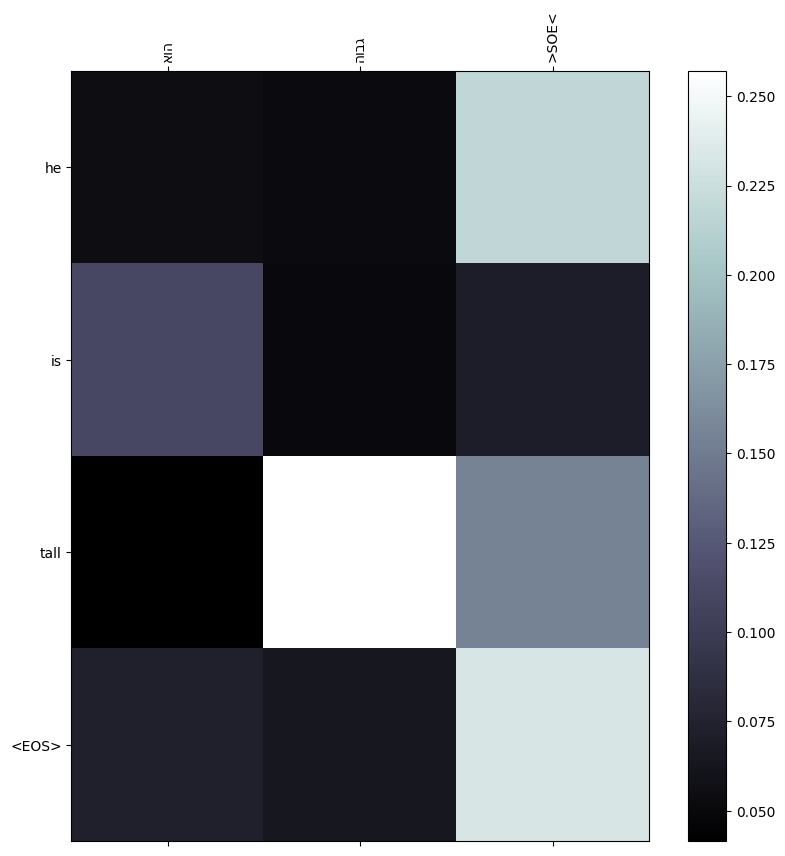

Example 2:
Input Sentence: אני עייף
Output Sentence: i am tired <EOS>


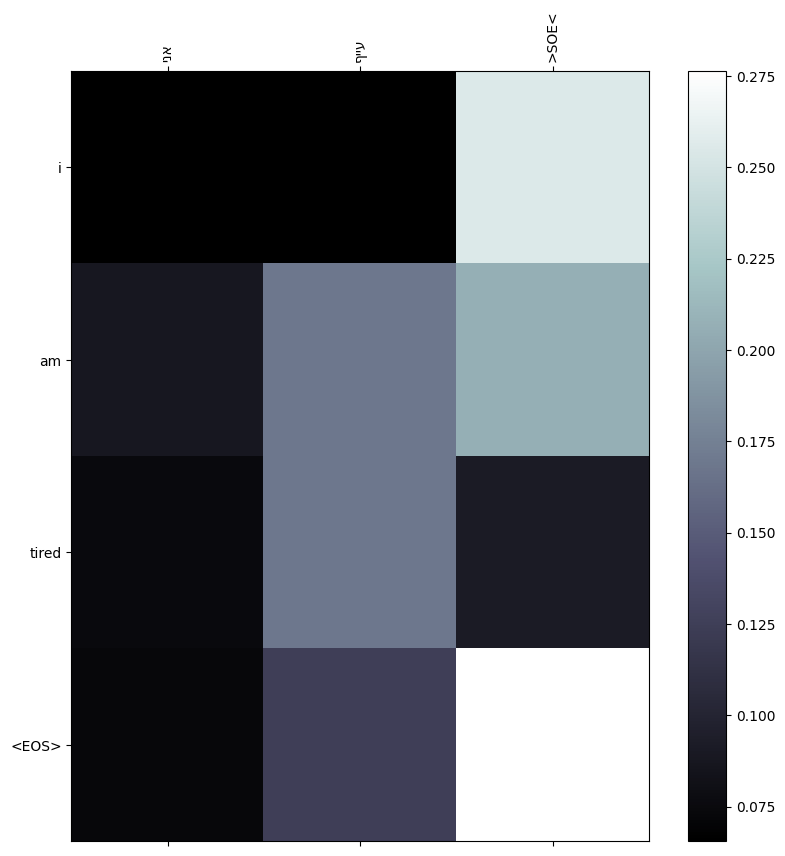

Example 3:
Input Sentence: הוא גבוה
Output Sentence: he is tall <EOS>


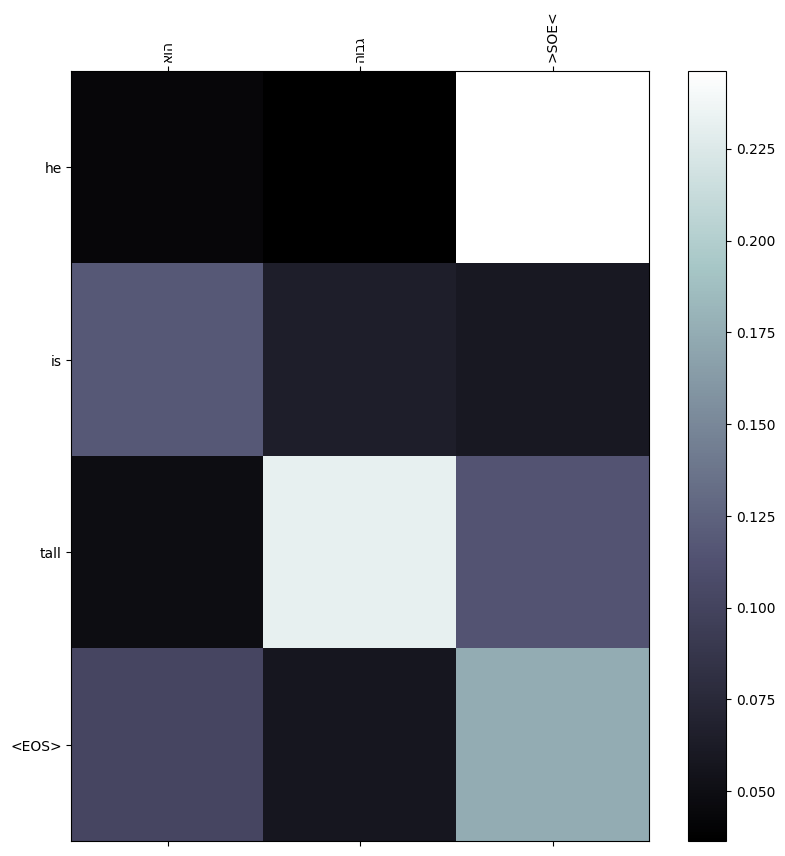

Example 4:
Input Sentence: הוא גבוה
Output Sentence: he is tall <EOS>


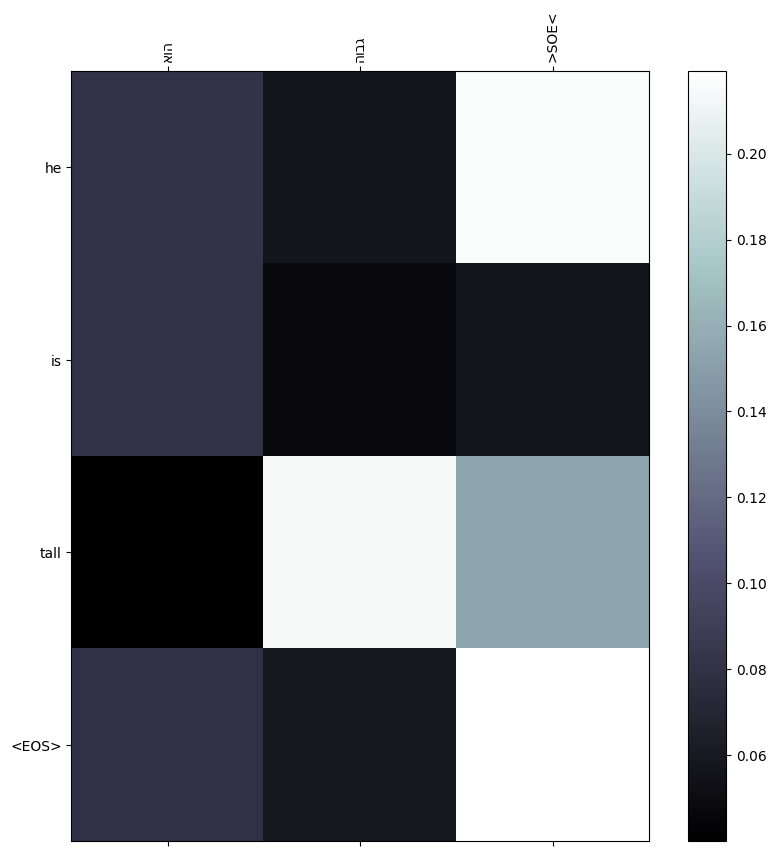

Example 5:
Input Sentence: אני עייף
Output Sentence: i am tired <EOS>


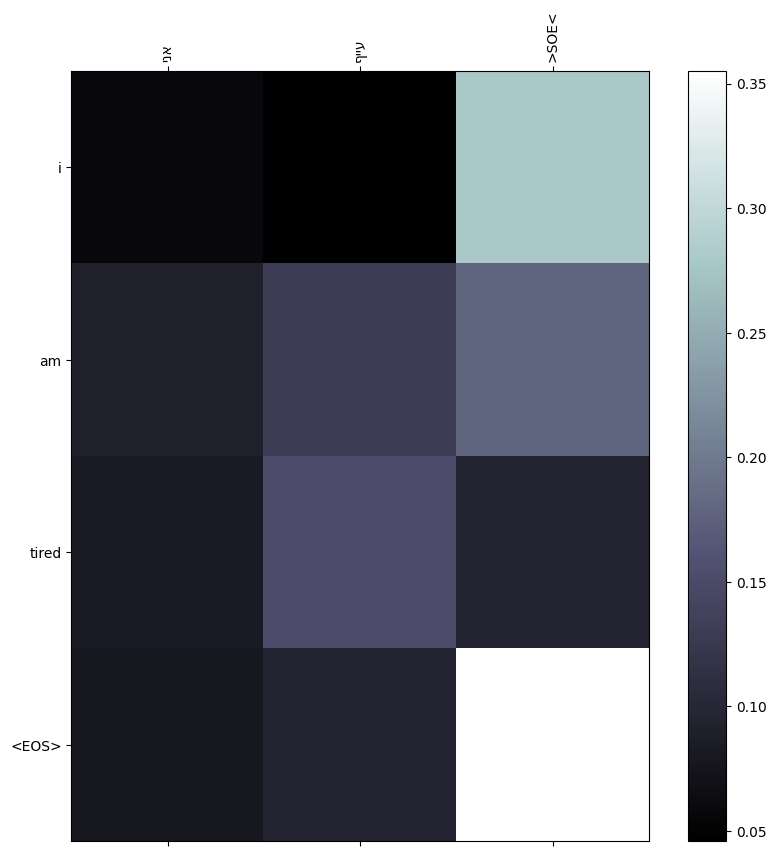

In [40]:
# Function to visualize attention
def show_attention(input_sentence, output_words, attentions):
    # Ensure attentions is 2D
    if attentions.dim() == 1:
        attentions = attentions.unsqueeze(0)  # Add a dimension if necessary
    attentions = attentions.cpu().detach().numpy()  # Convert to numpy array

    # Crop the attention matrix to match the input and output lengths
    cropped_attentions = attentions[:len(output_words), :len(input_sentence.split(' ') + ['<EOS>'])]

    # Reverse each word in the input sentence for proper Hebrew display
    input_labels = input_sentence.split(' ') + ['<EOS>']
    reversed_input_labels = [''.join(reversed(word)) for word in input_labels]  # Reverse the characters of each word

    # Plot the attention matrix
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cropped_attentions, cmap='bone')

    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(range(len(reversed_input_labels)))
    ax.set_yticks(range(len(output_words)))
    ax.set_xticklabels(reversed_input_labels, rotation=90)  # Display reversed words
    ax.set_yticklabels(output_words)

    plt.show()

# Function to evaluate and show attention for a single sentence
def evaluate_and_show_attention(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden

        decoded_words = []
        attentions = torch.zeros(MAX_LENGTH, MAX_LENGTH)

        for di in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            attentions[di] = attn_weights.data
            topv, topi = decoder_output.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        attentions = attentions[:len(decoded_words), :input_length]
        print(f'Input Sentence: {sentence}')
        print(f'Output Sentence: {" ".join(decoded_words)}')
        show_attention(sentence, decoded_words, attentions)

# Generate attention plots for 5 random sentences
def show_attention_for_random_sentences(encoder, decoder, pairs, input_lang, output_lang, n=5):
    for i in range(n):
        pair = random.choice(pairs)
        print(f'Example {i + 1}:')
        evaluate_and_show_attention(encoder, decoder, pair[0], input_lang, output_lang)

# Display attention plots for 5 random sentences
show_attention_for_random_sentences(encoder, decoder, pairs, input_lang, output_lang, n=5)

3) Do you think this model performs well? Why or why not? What are its limitations/disadvantages? What would you do to improve it?  


# **Answer 3)**

Performance:

The model has limitations that affect its performance. While it may perform reasonably well on sentences within the filtered training data (eng_prefixes), it struggles to generalize to unseen sentence structures or words, as the vocabulary and diversity are restricted by the filter. Additionally, its limited size and training data may hinder its ability to capture complex linguistic relationships, leading to suboptimal translations for longer or more diverse sentences. Thus, the model’s performance is acceptable within the constraints of its training data but is inadequate for broader, real-world use cases.

Limitations:

The model has several limitations. Its vocabulary and linguistic diversity are restricted by the eng_prefixes filter, which limits its ability to generalize to sentences outside the training data. It also struggles with longer or complex sentences due to the fixed MAX_LENGTH parameter and the relatively small hidden size, which constrain its capacity to handle complex linguistic patterns. Furthermore, the dataset may not provide sufficient examples for effective training, and the lack of advanced techniques like pretraining or larger architectures reduces its overall performance. These constraints make the model suitable for basic translations but inadequate for more diverse or nuanced tasks.

Improvements:

1) Expand the Dataset:

Use a larger and more diverse dataset without filtering too strictly by prefixes to increase vocabulary and linguistic diversity.

2) Increase Model Capacity:

Increase the hidden size or use more advanced architectures like Transformer based models for better handling of complex linguistic patterns.

3) Regularization and Optimization:

Apply techniques like gradient clipping, or better optimizers to stabilize training and prevent overfitting.

4) Data Augmentation:

Using techniques like back translation to create additional training data, further improving the model’s generalization.

5) Incorporate Pretrained Embeddings:

Use pretrained word embeddings for Hebrew and English to provide the model with richer word representations.

6) Increase Computational Resources:

Train the model for more epochs to ensure better convergence.


4) Using any neural network architecture of your liking, build  a model with the aim to beat the model in 2.a. Compare your results in a meaningful way, and add a short explanation to why you think/thought your suggested network is better.

# **Answer 4)**

Explanation of the Improvements:

The improved model performed better because of its larger capacity, diverse dataset, and the use of the Adam optimizer. Additionally, I increased the maximum sentence length to 15 words, allowing for more complex and realistic sentence pairs in training. The larger hidden size allowed the model to capture more nuanced relationships between input and output sequences, while the Adam optimizer improved convergence, reducing the chances of getting stuck in poor local minima.

The expanded dataset introduced variability and complexity, which pushed the improved model to learn generalizable patterns instead of memorizing the data. While both models achieved perfect accuracy on their respective datasets, the improved model is better equipped to generalize to unseen examples due to its enhancements.

Word-Level Accuracy of the model in Q2: 0.9167
Word-Level Accuracy of the current model: 1.0

In [56]:
import torch.optim as optim
import random
import re
import math
import time



MAX_LENGTH = 15  # Increased to allow longer sentences
hidden_size = 256  # Increased hidden size for better capacity
epochs = 50
SOS_token = 0
EOS_token = 1

# Helper Functions
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {s:.0f}s'

def timeSince(since, percent):
    now = time.time()
    elapsed = now - since
    estimated_total = elapsed / percent
    remaining = estimated_total - elapsed
    return f'{asMinutes(elapsed)} (- {asMinutes(remaining)})'

# Language Class
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Preprocess Data
def prepareData(lang1, lang2, pairs):
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    print(f"Read {len(pairs)} sentence pairs")
    pairs = [pair for pair in pairs if len(pair[0].split()) < MAX_LENGTH and len(pair[1].split()) < MAX_LENGTH]
    print(f"Trimmed to {len(pairs)} sentence pairs")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

# Encoder Model
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

# Decoder with Attention
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attn = nn.Linear(hidden_size * 2, max_length)
        self.attn_combine = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = torch.nn.functional.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1
        )
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = torch.nn.functional.relu(output)
        output, hidden = self.gru(output, hidden)
        output = torch.nn.functional.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

# Training
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]])
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < 0.5 else False

    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden, _ = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, _ = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

# Evaluation
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]])
        decoder_hidden = encoder_hidden

        decoded_words = []
        for di in range(MAX_LENGTH):
            decoder_output, decoder_hidden, _ = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            topv, topi = decoder_output.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

# Helper Functions
def tensorFromSentence(lang, sentence):
    indexes = [lang.word2index[word] for word in sentence.split(' ')]
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long).view(-1, 1)

# Word-Level Accuracy
def compute_word_accuracy(encoder, decoder, pairs, input_lang, output_lang):
    total_words = 0
    correct_words = 0

    for pair in pairs:
        input_sentence, target_sentence = pair
        predicted_words = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
        predicted_words = [word for word in predicted_words if word != '<EOS>']
        target_words = target_sentence.split()

        for pred_word, ref_word in zip(predicted_words, target_words):
            if pred_word == ref_word:
                correct_words += 1
            total_words += 1

    accuracy = correct_words / total_words if total_words > 0 else 0
    print(f"Word-Level Accuracy: {accuracy:.4f}")
    return accuracy

# Expanded Dataset
pairs = [
    ["אני שמח", "i am happy"],
    ["אני עייף", "i am tired"],
    ["הוא גבוה", "he is tall"],
    ["היא נמוכה", "she is short"],
    ["אני אוהב ללמוד", "i love learning"],
    ["אתה חכם מאוד", "you are very smart"],
    ["היא גרה בעיר הגדולה", "she lives in the big city"],
    ["אני רוצה לאכול", "i want to eat"],
    ["הם מטיילים ביער", "they are walking in the forest"]
]

# Prepare Data
input_lang, output_lang, pairs = prepareData('heb', 'eng', pairs)

# Initialize Models
encoder = EncoderRNN(input_lang.n_words, hidden_size)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words)

encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)  # Use Adam optimizer
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)
criterion = nn.NLLLoss()

# Train the Model
for epoch in range(1, epochs + 1):
    for pair in pairs:
        input_tensor = tensorFromSentence(input_lang, pair[0])
        target_tensor = tensorFromSentence(output_lang, pair[1])
        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
    print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Evaluate
for pair in pairs:
    print(f"Input: {pair[0]}")
    print(f"Target: {pair[1]}")
    output_words = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
    print(f"Predicted: {' '.join(output_words)}")

# Compute Accuracy
compute_word_accuracy(encoder, decoder, pairs, input_lang, output_lang)




Read 9 sentence pairs
Trimmed to 9 sentence pairs
Counted words:
heb 22
eng 28
Epoch 1, Loss: 3.4166
Epoch 2, Loss: 2.7168
Epoch 3, Loss: 1.1721
Epoch 4, Loss: 1.6244
Epoch 5, Loss: 0.9653
Epoch 6, Loss: 0.5052
Epoch 7, Loss: 0.1915
Epoch 8, Loss: 0.1022
Epoch 9, Loss: 0.0573
Epoch 10, Loss: 0.0395
Epoch 11, Loss: 0.0300
Epoch 12, Loss: 0.0245
Epoch 13, Loss: 0.0205
Epoch 14, Loss: 0.0175
Epoch 15, Loss: 0.0164
Epoch 16, Loss: 0.0144
Epoch 17, Loss: 0.0130
Epoch 18, Loss: 0.0122
Epoch 19, Loss: 0.0106
Epoch 20, Loss: 0.0103
Epoch 21, Loss: 0.0094
Epoch 22, Loss: 0.0087
Epoch 23, Loss: 0.0080
Epoch 24, Loss: 0.0075
Epoch 25, Loss: 0.0073
Epoch 26, Loss: 0.0064
Epoch 27, Loss: 0.0062
Epoch 28, Loss: 0.0058
Epoch 29, Loss: 0.0055
Epoch 30, Loss: 0.0052
Epoch 31, Loss: 0.0049
Epoch 32, Loss: 0.0047
Epoch 33, Loss: 0.0046
Epoch 34, Loss: 0.0045
Epoch 35, Loss: 0.0042
Epoch 36, Loss: 0.0038
Epoch 37, Loss: 0.0037
Epoch 38, Loss: 0.0035
Epoch 39, Loss: 0.0036
Epoch 40, Loss: 0.0033
Epoch 41, 

1.0

In [ ]:
# use the following parameters:
MAX_LENGTH = 10
hidden_size = 128
epochs = 50

SOLUTION:

In [ ]:
### ANSWERS ABOVE: CODE + EXPLANATIONS